In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:2]:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/facesdataset/imageszip/Images/AF219.jpg
/kaggle/input/facesdataset/imageszip/Images/AM254.jpg


In [2]:
import time


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

def show_images(images):
    f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, sharey=True)
    ax1.imshow(np.array(images[0].permute(1,2,0)))#.reshape([350,350,3]),dtype=int))
    ax2.imshow(np.array(images[1].permute(1,2,0)))#.reshape([350,350,3]),dtype=int))
    ax3.imshow(np.array(images[2].permute(1,2,0)))
    ax4.imshow(np.array(images[3].permute(1,2,0)))

    plt.show()

In [4]:
#PATH_TRAIN='/kaggle/input/labelsimage/Images_preprocess/'
PATH_TRAIN='/kaggle/input/facesdataset/imageszip/Images/'
batch_size = 64
ind = np.array(list(range(len(os.listdir(PATH_TRAIN)))))
np.random.shuffle(ind)
sample_train=dict(zip(list(range(int(len(ind)*0.9))),np.array(os.listdir(PATH_TRAIN))[ind[:int(len(ind)*0.9)]]))
sample_test=dict(zip(list(range(int(len(ind)*0.1))),np.array(os.listdir(PATH_TRAIN))[ind[int(len(ind)*0.9):]]))
#127.5) * 0.0078125

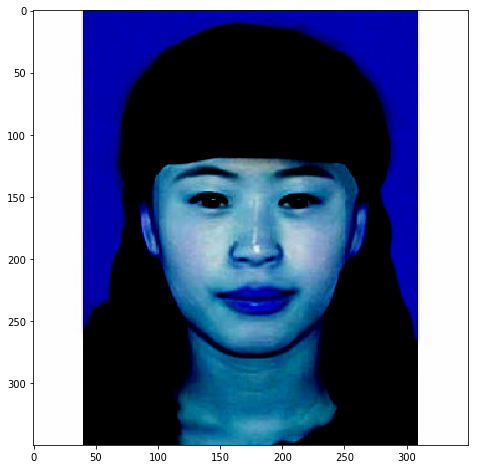

In [5]:
plt.imshow((cv2.imread(PATH_TRAIN+'AF1.jpg')-127.5)*0.0078125)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DetectionDataset(torch.utils.data.Dataset):
    
    def __init__(self, sample):
        self.sample=sample        
    def __len__(self):
        return len(self.sample)
    
    def __getitem__(self, idx):
        img = cv2.imread(PATH_TRAIN+self.sample[idx])[:,:,::-1]
        img = DetectionDataset.preprocess_img(img)
        return img
    
    @staticmethod
    def preprocess_img(img, dsize=(256,256)):
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32)
        img=(img - 127.5) * 0.0078125
        img = np.moveaxis(img, -1, 0)
        return torch.Tensor(img)
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [7]:
dataset = DetectionDataset(sample=sample_train)
loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

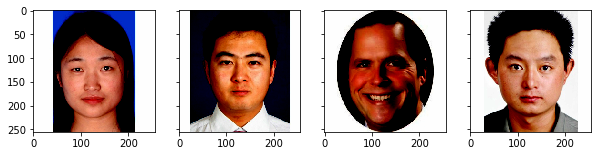

In [8]:
for x in loader_train:
    show_images(x)#[0].permute(1,2,0))
    break

In [9]:
NOISE_DIM = 4096
batch_size = 64
dtype=torch.FloatTensor
datasett = DetectionDataset(sample=sample_test)
loader_val = torch.utils.data.DataLoader(datasett, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

In [10]:
def sample_noise(batch_size, dim):
    return torch.FloatTensor(batch_size, dim).uniform_(-1, 1)

In [11]:
def get_optimizer(model):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,betas=[0.5,0.999])
    return optimizer

In [12]:
def bce_loss(input, target):
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()
def discriminator_loss(logits_real, logits_fake):
    loss = bce_loss(logits_real,torch.ones(logits_real.size()).to(device))+ bce_loss(logits_fake,torch.zeros(logits_fake.size()).to(device))
    return loss

def generator_loss(logits_fake):
    loss = bce_loss(logits_fake,torch.ones(logits_fake.size()).to(device))
    return loss

In [13]:
def ls_discriminator_loss(scores_real, scores_fake):
    loss= torch.mean(((scores_fake)**2))/2
    loss+= torch.mean(((1-scores_real)**2))/2
    return loss

def ls_generator_loss(scores_fake):
    loss = torch.mean(((scores_fake-1)**2))/2#,torch.ones(scores_fake.size()))/2
    return loss

In [17]:
class EncoderConv(nn.Module):
    def __init__(self,noise_dim=NOISE_DIM):
        super(EncoderConv, self).__init__()
        self.conv2dTransp1 = nn.ConvTranspose2d(in_channels=4096,out_channels=256,kernel_size=4,stride=2,padding=0)
        self.batch_norm_t1=nn.BatchNorm2d(256)
        self.conv2dTransp2 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=4,padding=2)#,stride=2,padding=0)
        self.batch_norm_t2=nn.BatchNorm2d(256)
        self.conv2dTransp3 = nn.Conv2d(in_channels=256,out_channels=2*64,kernel_size=4,padding=1)#,stride=2,padding=0)
        self.batch_norm_t3=nn.BatchNorm2d(2*64)
        self.conv2dTransp4 = nn.Conv2d(in_channels=2*64,out_channels=64,kernel_size=3,padding=0)#,stride=1,padding=0)
        self.batch_norm_t4=nn.BatchNorm2d(64)
        self.conv2dTransp5 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,padding=1)#,stride=2,padding=0)
        self.batch_norm_t5=nn.BatchNorm2d(32)
        self.conv2dTransp6 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,padding=1)#,stride=2,padding=0)
        self.batch_norm_t6=nn.BatchNorm2d(16)
        self.activ=nn.ReLU()
        self.upsample=nn.UpsamplingNearest2d(scale_factor=(2,2))
        self.conv2dTransp7 = nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3,padding=1)#,stride=2,padding=0)
        self.batch_norm_t7=nn.BatchNorm2d(8)

        self.conv2dTransp8 = nn.Conv2d(in_channels=8,out_channels=3,kernel_size=3,padding=1)#,stride=2,padding=0)
        self.tanh = nn.Tanh()
    def forward(self,x):
        x=x.view(-1,4096,1,1)
        x=self.activ(self.conv2dTransp1(x))
        x=self.upsample(self.activ(self.batch_norm_t2(self.conv2dTransp2(x))))
        x=self.upsample(self.activ(self.batch_norm_t3(self.conv2dTransp3(x))))
        x=self.upsample(self.activ(self.batch_norm_t4(self.conv2dTransp4(x))))
        x=self.upsample(self.activ(self.batch_norm_t5(self.conv2dTransp5(x))))
        x=self.upsample(self.activ(self.batch_norm_t6(self.conv2dTransp6(x))))
        x=self.upsample(self.activ(self.batch_norm_t7(self.conv2dTransp7(x))))
        x=self.conv2dTransp8(x)
        x=self.tanh(x)
        return x.view(-1,3,256,256)

In [16]:
nn.UpsamplingNearest2d(scale_factor=(2,2))(torch.rand(1,1,2,2))

tensor([[[[0.7380, 0.7380, 0.5810, 0.5810],
          [0.7380, 0.7380, 0.5810, 0.5810],
          [0.1816, 0.1816, 0.9748, 0.9748],
          [0.1816, 0.1816, 0.9748, 0.9748]]]])

In [18]:
class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv,self).__init__()
        self.activ=nn.LeakyReLU(0.2)
        self.conv1=nn.Conv2d(3,8,3,padding=1)
        self.batch_norm1=nn.BatchNorm2d(8)
        self.conv2=nn.Conv2d(8,16,3,padding=1)
        self.batch_norm2=nn.BatchNorm2d(16)
        self.conv3=nn.Conv2d(16,32,3,padding=1)
        self.batch_norm3=nn.BatchNorm2d(32)
        self.pool = nn.AvgPool2d(2)
        self.conv4=nn.Conv2d(32,64,3,padding=1)
        self.batch_norm4=nn.BatchNorm2d(64)
        self.conv5=nn.Conv2d(64,128,3,padding=1)
        self.batch_norm5=nn.BatchNorm2d(128)
        self.conv6=nn.Conv2d(128,256,3,padding=1)
        self.batch_norm6=nn.BatchNorm2d(256)
        self.dropout=nn.Dropout2d(0.25)
        self.batch_norm7=nn.BatchNorm1d(128)
        self.linear1=nn.Linear(256*4*4,128)
        self.linear2=nn.Linear(128,1)
    def forward(self, x):
        x=self.pool(self.dropout(self.activ(self.conv1(x))))
        x=self.pool(self.dropout(self.activ(self.batch_norm2(self.conv2(x)))))
        
        x=self.pool(self.dropout(self.activ(self.batch_norm3(self.conv3(x)))))
        
        x=self.pool(self.dropout(self.activ(self.batch_norm4(self.conv4(x)))))

        x=self.pool(self.dropout(self.activ(self.batch_norm5(self.conv5(x)))))

        x=self.pool(self.dropout(self.activ(self.batch_norm6(self.conv6(x)))))
        x=x.view(-1,256*4*4)
        x=self.activ(self.linear1(x))
        x=self.linear2(x)
        return x.view(-1,1)


In [ ]:
DiscriminatorConv()(torch.rand(2,3,256,256))

In [19]:
G_DC = EncoderConv().type(dtype).to(device)
#G_DC=G_DC.apply(initialize_weights)
D_DC = DiscriminatorConv().type(dtype).to(device)
#D_DC=D_DC.apply(initialize_weights)


In [ ]:
device

In [20]:
dtype=torch.FloatTensor
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=50, 
              batch_size=64, noise_size=4096, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0

    for epoch in range(num_epochs):
        for x in loader_train:
            D_solver.zero_grad()
            real_data = x.type(dtype).to(device)#.permute(1,2,3,0)
            logits_real = D(real_data).type(dtype).to(device)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype).to(device)
            #print(g_fake_seed.shape)
            fake_images = G(g_fake_seed).detach()


            logits_fake = D(fake_images)
            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()
            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype).to(device)
            fake_images = G(g_fake_seed)
            gen_logits_fake = D(fake_images)
            g_error = generator_loss(gen_logits_fake.to(device))
            g_error.backward()
            G_solver.step()
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()),'epoch',epoch)
                imgs_numpy = fake_images.data.cpu()
                #imgs_numpy=real_data.data.cpu()
                show_images(imgs_numpy)
                print()
            iter_count += 1


In [21]:
D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)


Iter: 0, D: 0.4062, G:6.474 epoch 0


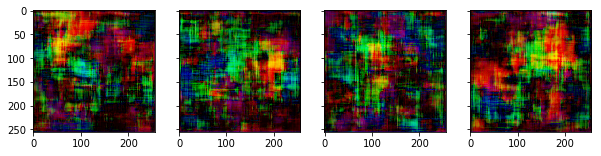


Iter: 250, D: 0.222, G:0.4607 epoch 3


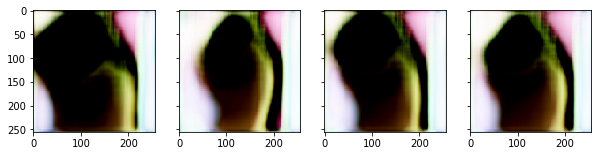


Iter: 500, D: 0.3337, G:0.1774 epoch 6


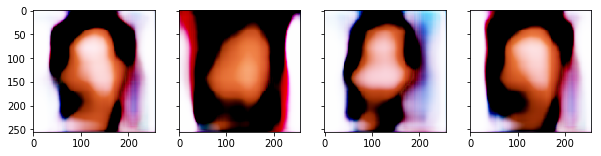


Iter: 750, D: 0.2037, G:0.2312 epoch 9


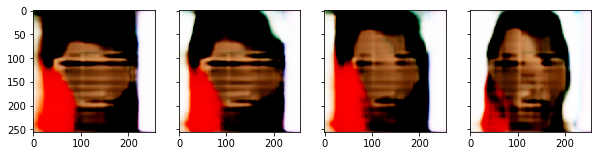


Iter: 1000, D: 0.2297, G:0.3681 epoch 12


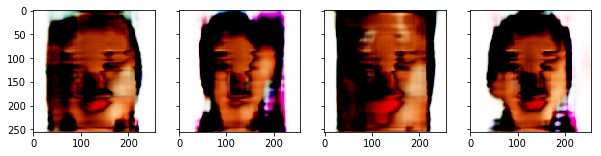


Iter: 1250, D: 0.1599, G:0.3072 epoch 16


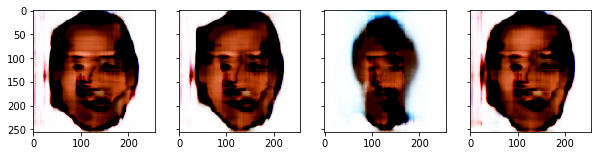


Iter: 1500, D: 0.1701, G:0.3012 epoch 19


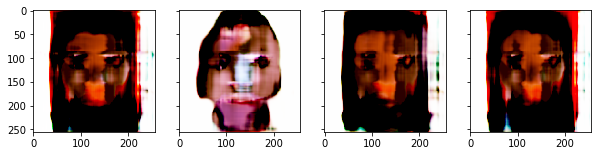


Iter: 1750, D: 0.135, G:0.3944 epoch 22


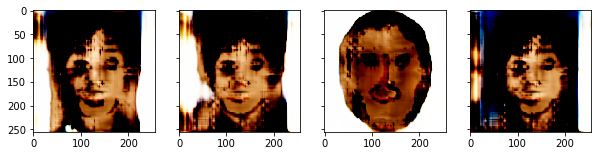


Iter: 2000, D: 0.1676, G:0.2866 epoch 25


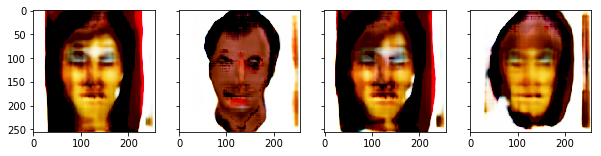


Iter: 2250, D: 0.09301, G:0.4054 epoch 29


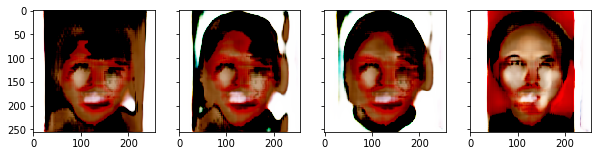


Iter: 2500, D: 0.1646, G:0.171 epoch 32


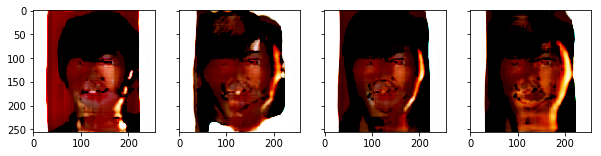


Iter: 2750, D: 0.1202, G:0.3364 epoch 35


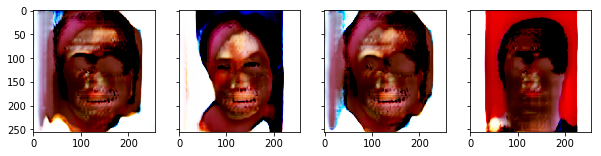


Iter: 3000, D: 0.1927, G:0.2739 epoch 38


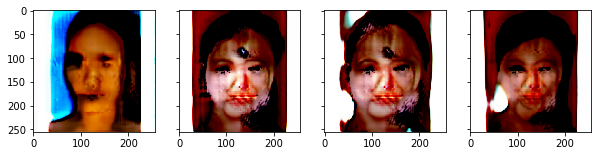


Iter: 3250, D: 0.08633, G:0.326 epoch 42


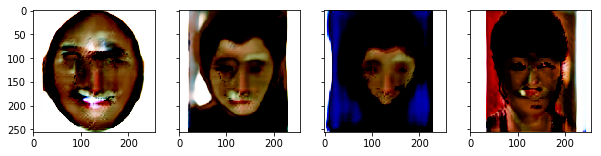


Iter: 3500, D: 0.07974, G:0.3915 epoch 45


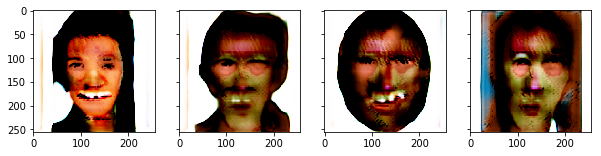


Iter: 3750, D: 0.1691, G:0.3155 epoch 48


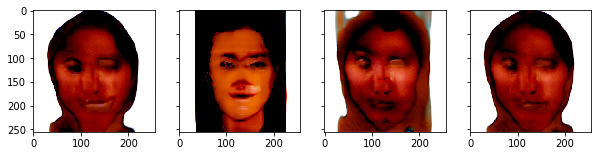


Iter: 4000, D: 0.05796, G:0.3705 epoch 51


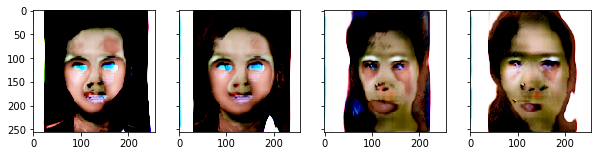


Iter: 4250, D: 0.1082, G:0.4247 epoch 55


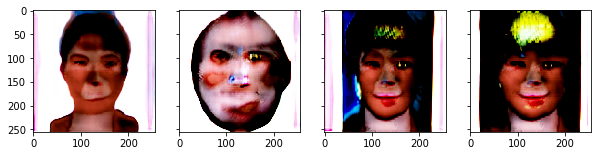


Iter: 4500, D: 0.114, G:0.5155 epoch 58


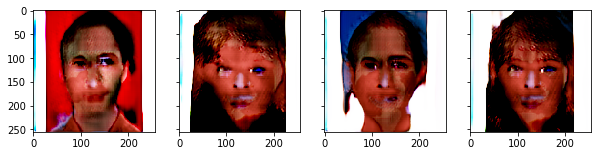


Iter: 4750, D: 0.07008, G:0.4591 epoch 61


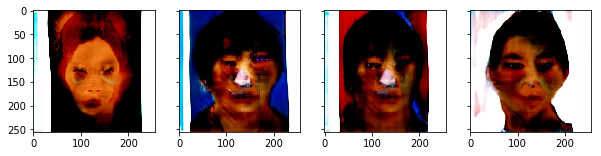


Iter: 5000, D: 0.08582, G:0.3032 epoch 64


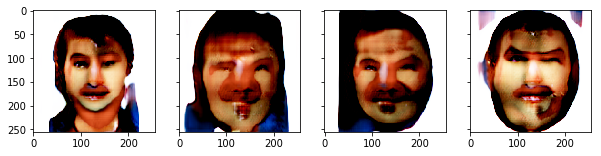


Iter: 5250, D: 0.08778, G:0.511 epoch 68


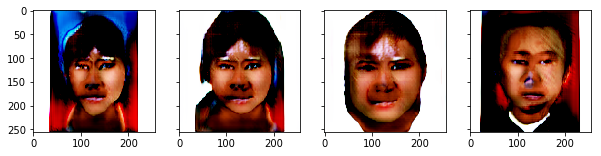


Iter: 5500, D: 0.1225, G:0.4161 epoch 71


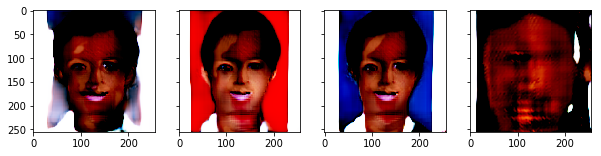


Iter: 5750, D: 0.06193, G:0.3704 epoch 74


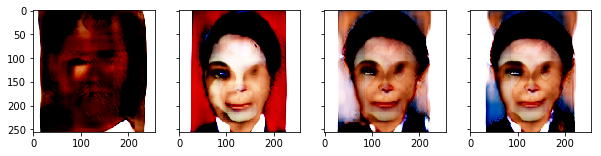


Iter: 6000, D: 0.08973, G:0.4031 epoch 77


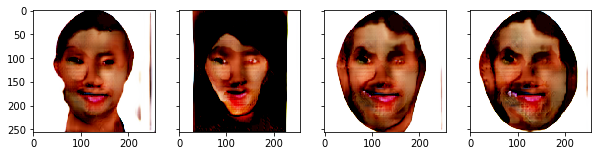


Iter: 6250, D: 0.08694, G:0.2871 epoch 81


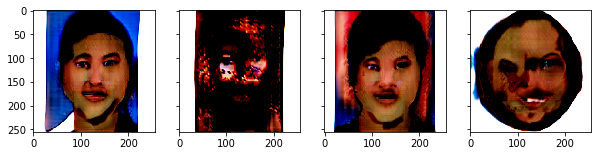


Iter: 6500, D: 0.05542, G:0.5847 epoch 84


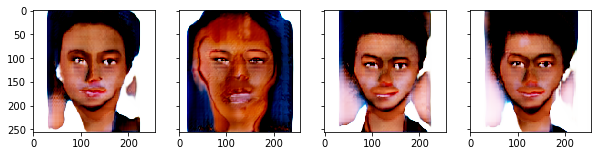


Iter: 6750, D: 0.06059, G:0.4978 epoch 87


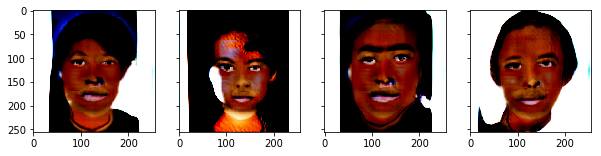


Iter: 7000, D: 0.06184, G:0.4508 epoch 90


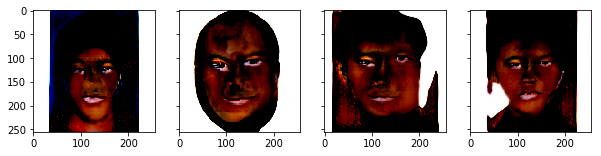


Iter: 7250, D: 0.04982, G:0.5066 epoch 94


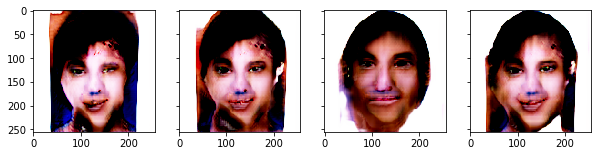


Iter: 7500, D: 0.05419, G:0.4089 epoch 97


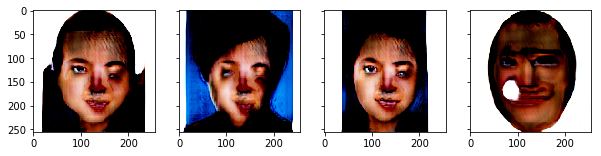


Iter: 7750, D: 0.05661, G:0.3327 epoch 100


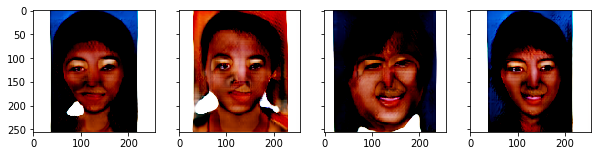


Iter: 8000, D: 0.08343, G:0.3965 epoch 103


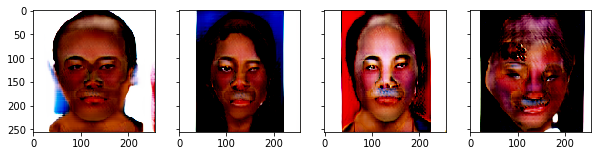


Iter: 8250, D: 0.04092, G:0.4974 epoch 107


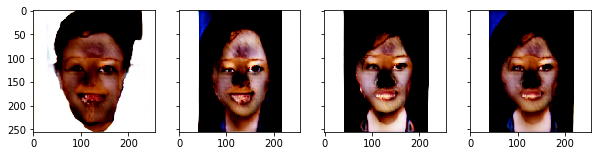


Iter: 8500, D: 0.02399, G:0.4625 epoch 110


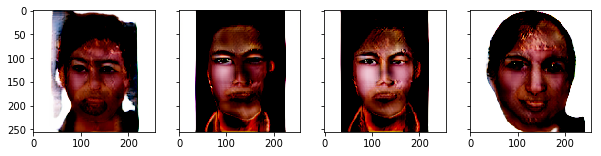


Iter: 8750, D: 0.0476, G:0.4005 epoch 113


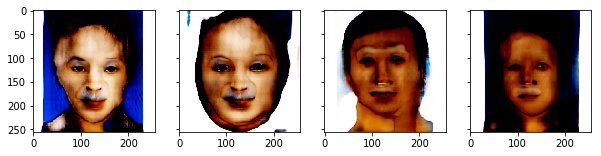


Iter: 9000, D: 0.05977, G:0.3315 epoch 116


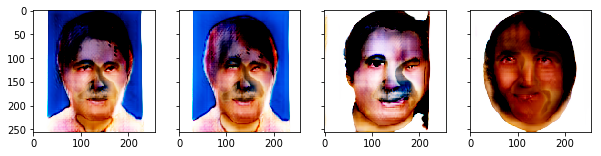


Iter: 9250, D: 0.05171, G:0.4108 epoch 120


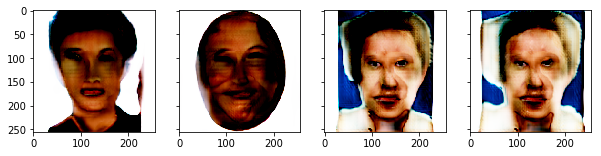


Iter: 9500, D: 0.03341, G:0.4726 epoch 123


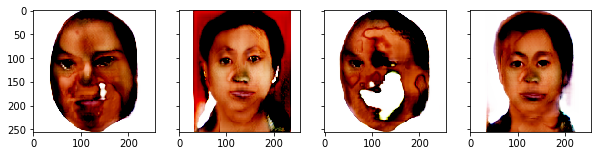


Iter: 9750, D: 0.02064, G:0.4949 epoch 126


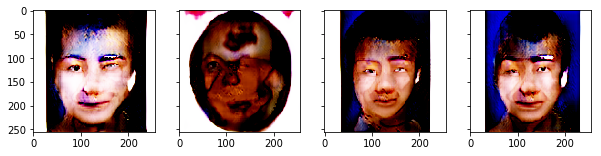


Iter: 10000, D: 0.05805, G:0.4707 epoch 129


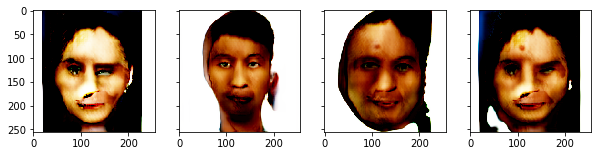


Iter: 10250, D: 0.02687, G:0.464 epoch 133


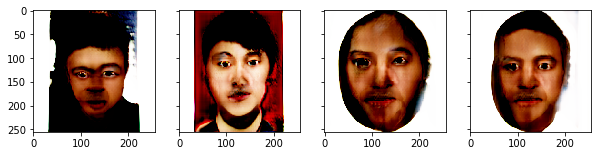


Iter: 10500, D: 0.0362, G:0.4144 epoch 136


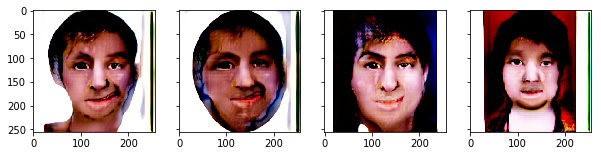


Iter: 10750, D: 0.0227, G:0.4784 epoch 139


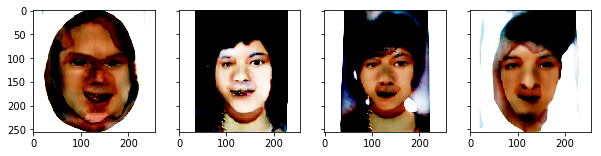


Iter: 11000, D: 0.03977, G:0.4588 epoch 142


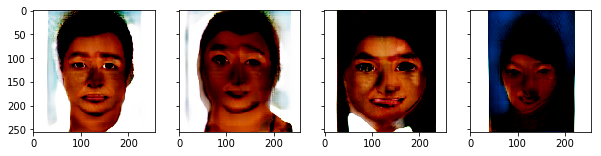


Iter: 11250, D: 0.0319, G:0.3804 epoch 146


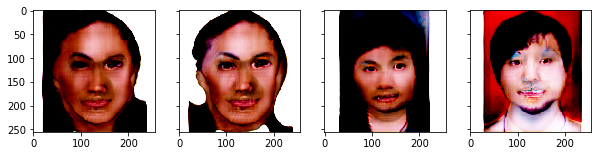


Iter: 11500, D: 0.02675, G:0.3365 epoch 149


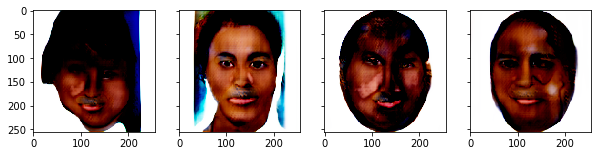


Iter: 11750, D: 0.0641, G:0.5458 epoch 152


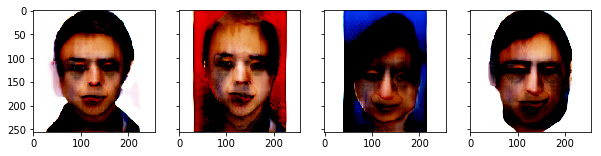


Iter: 12000, D: 0.01504, G:0.4389 epoch 155


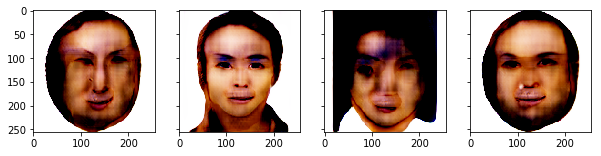


Iter: 12250, D: 0.02809, G:0.4216 epoch 159


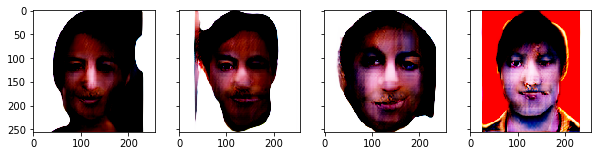


Iter: 12500, D: 0.03745, G:0.4255 epoch 162


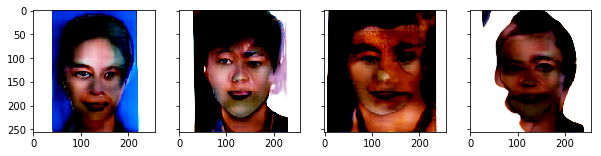


Iter: 12750, D: 0.02012, G:0.4829 epoch 165


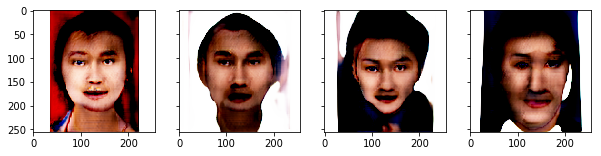


Iter: 13000, D: 0.02497, G:0.3891 epoch 168


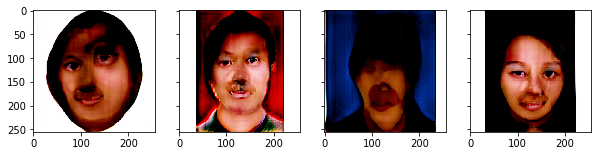


Iter: 13250, D: 0.05498, G:0.548 epoch 172


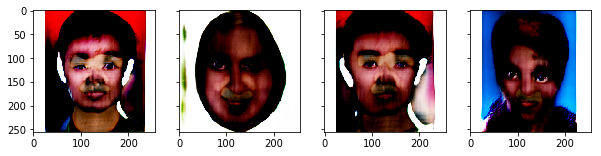


Iter: 13500, D: 0.03294, G:0.4418 epoch 175


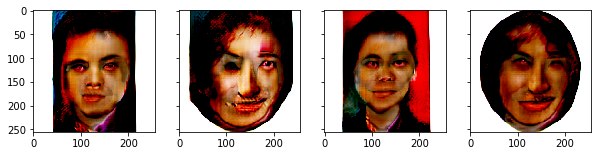


Iter: 13750, D: 0.04572, G:0.5161 epoch 178


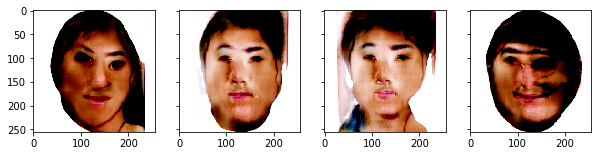


Iter: 14000, D: 0.07746, G:0.5995 epoch 181


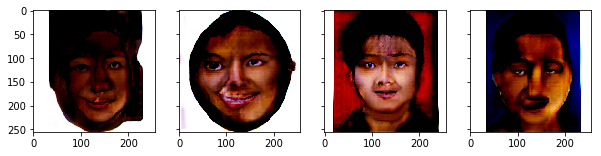


Iter: 14250, D: 0.04815, G:0.5687 epoch 185


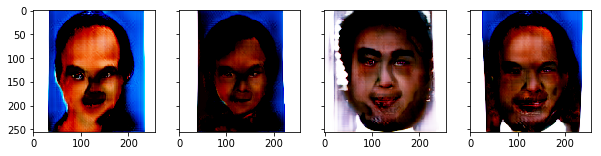


Iter: 14500, D: 0.04934, G:0.5639 epoch 188


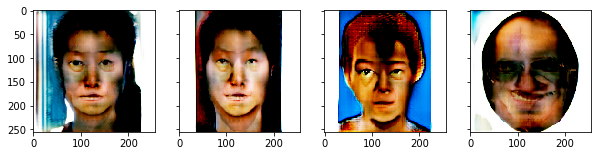


Iter: 14750, D: 0.02254, G:0.4756 epoch 191


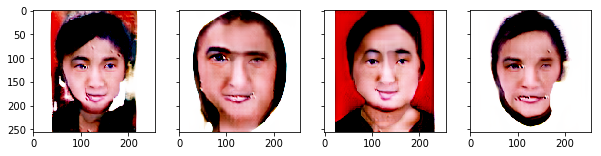


Iter: 15000, D: 0.03893, G:0.4743 epoch 194


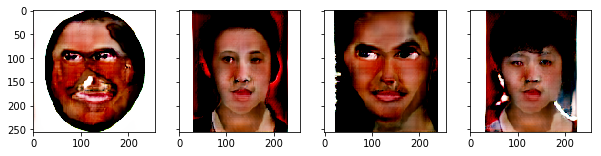


Iter: 15250, D: 0.01858, G:0.4607 epoch 198


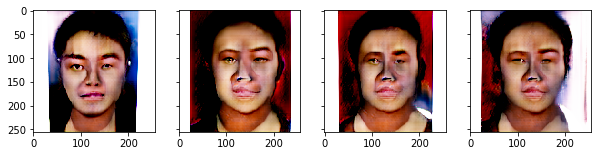


Iter: 15500, D: 0.1247, G:0.5604 epoch 201


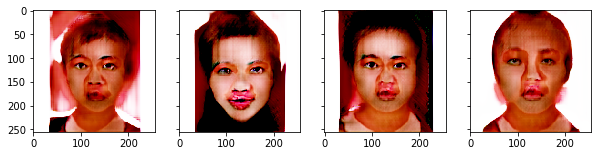


Iter: 15750, D: 0.08211, G:0.3716 epoch 204


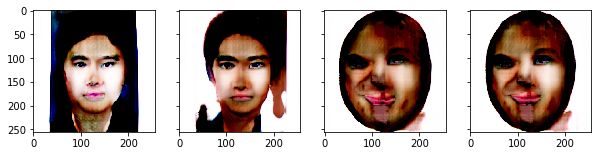


Iter: 16000, D: 0.01487, G:0.5108 epoch 207


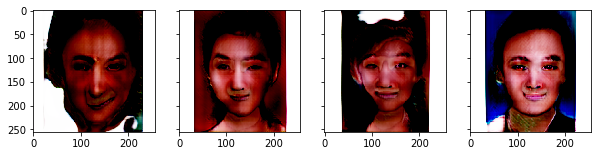


Iter: 16250, D: 0.01134, G:0.413 epoch 211


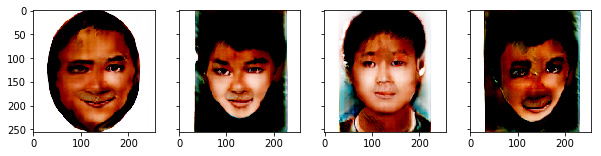


Iter: 16500, D: 0.009811, G:0.5113 epoch 214


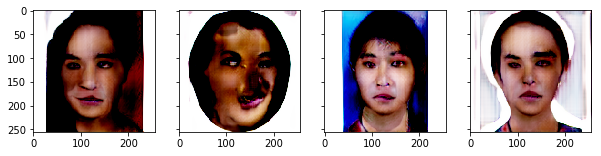


Iter: 16750, D: 0.06908, G:0.4931 epoch 217


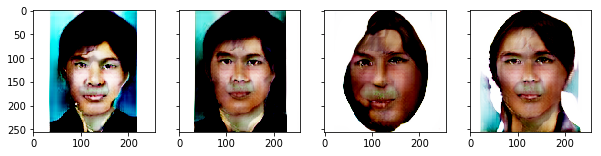


Iter: 17000, D: 0.00812, G:0.4944 epoch 220


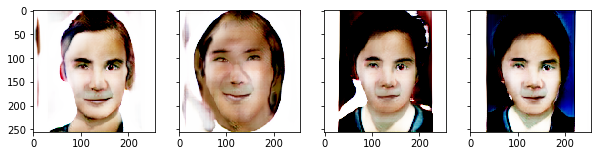


Iter: 17250, D: 0.05503, G:0.4455 epoch 224


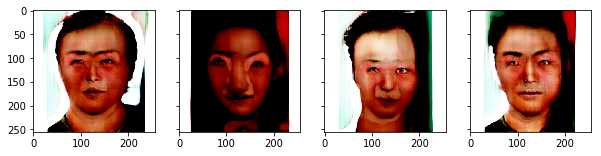


Iter: 17500, D: 0.00866, G:0.5124 epoch 227


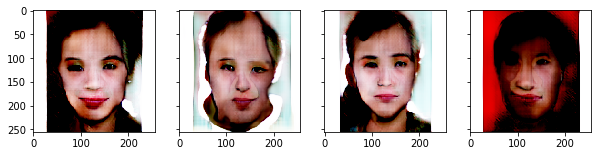


Iter: 17750, D: 0.00608, G:0.5229 epoch 230


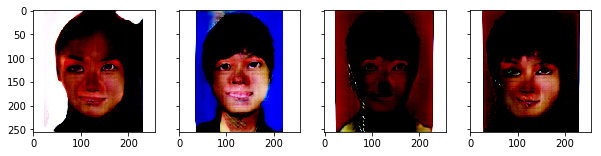


Iter: 18000, D: 0.03921, G:0.4895 epoch 233


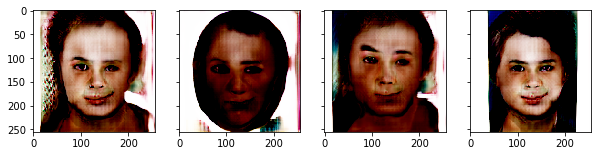


Iter: 18250, D: 0.07157, G:0.5562 epoch 237


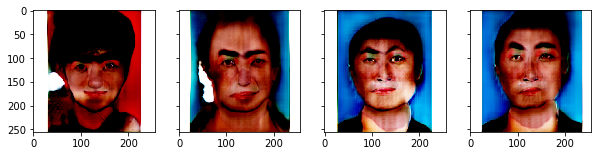


Iter: 18500, D: 0.01013, G:0.4803 epoch 240


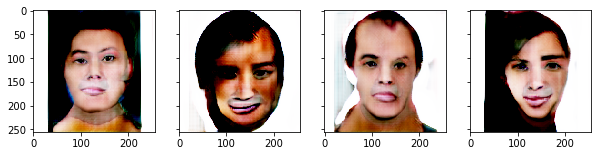


Iter: 18750, D: 0.01276, G:0.4492 epoch 243


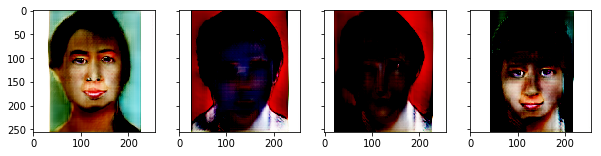


Iter: 19000, D: 0.00533, G:0.4811 epoch 246


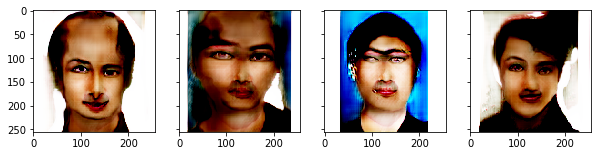


Iter: 19250, D: 0.005446, G:0.5022 epoch 250


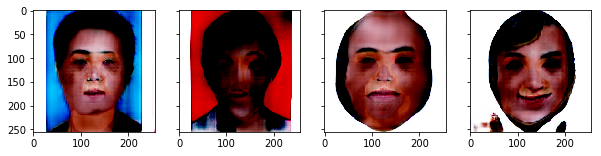


Iter: 19500, D: 0.01884, G:0.5083 epoch 253


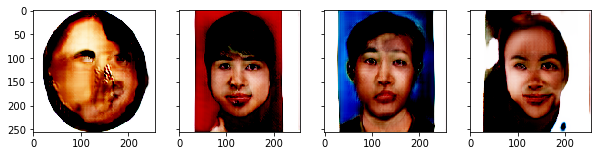


Iter: 19750, D: 0.05933, G:0.5506 epoch 256


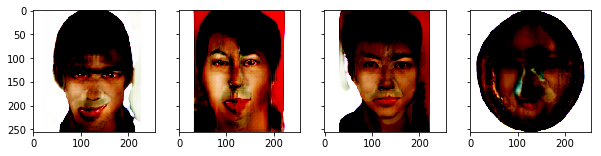


Iter: 20000, D: 0.03607, G:0.5271 epoch 259


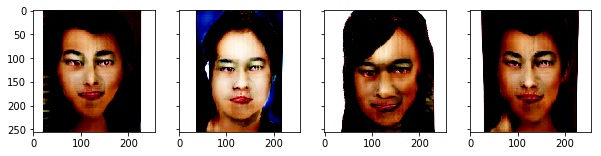

KeyboardInterrupt: 

In [22]:
run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, ls_discriminator_loss, ls_generator_loss, num_epochs=500,show_every=250)

In [23]:
from IPython.display import FileLink, FileLinks


In [24]:
torch.save(G_DC.state_dict(), 'generator_256_4096')


In [25]:
from IPython.display import FileLink, FileLinks
FileLink('generator_256_4096')

/kaggle/working/generator_256_4096

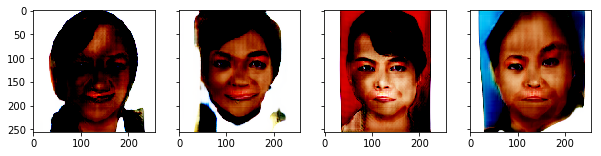

In [31]:
show_images(G_DC(sample_noise(4,4096).to(device)).detach().cpu())